### Run Distilled DAN, Non-distilled DAN, and Logistic Regression (GloVE-embedded input) Models
Run all of the following cells, in order

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import ast
from gensim.models import KeyedVectors
import nltk
import torch
from ast import literal_eval

Load Dataset

In [2]:
def load_datasets():
    """
    Load training and dev sets
    """

    train = pd.read_csv("./data/train_preprocessed.csv")
    dev = pd.read_csv("./data/val_preprocessed.csv")
    
    return train, dev

Tokenize Input Text and Add to Train and Dev Dataframes

In [3]:
def tokenizer(text: str):
    '''
    NLTK Tweet Tokenizer -- removes handles

    @param text        string tweet
    @ret tokens        list of tokens
    '''
    text = text.lower()
    tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True)
    tokens = tokenizer.tokenize(text)
    
    return tokens

Embed Input Text Tokens

In [4]:
def load_embeddings(filename):
    """
    Loads embeddings from embedding file and creates 
    1) dictionary of embedding words to indices
    2) list of embedding indices to words
    3) dense word embedding matrix
    """
    embeddings = KeyedVectors.load_word2vec_format(filename, binary=False, no_header=True)
    vocab2indx = dict(embeddings.key_to_index)
    idx2vocab = list(embeddings.index_to_key)
    embed_array = embeddings.vectors # matrix of dense word embeddings 
                                     # rows: a word 
                                     # columns: dimensions (50) of the dense embeddings
    return vocab2indx, idx2vocab, embed_array


def add_the_embedding(embed_array, vocab2indx): 
    """
    Adds "the" embedding to the embed_array matrix
    """
    the_embedding = embed_array[vocab2indx["the"]]
    out = np.vstack((embed_array, the_embedding))
    return out


def add_oov(idx2vocab, vocab2indx, embed_array):
    """
    Adds <OOV> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_oov_entry = len(embed_array)
    idx2vocab += ["<OOV>"]
    vocab2indx["<OOV>"] = new_oov_entry
    embed_array_w_oov = add_the_embedding(embed_array, vocab2indx)

    return idx2vocab, vocab2indx, embed_array_w_oov


def add_pad(idx2vocab, vocab2indx, embed_array):
    """
    Adds <PAD> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_pad_entry = len(embed_array)
    idx2vocab += ["<PAD>"]
    vocab2indx["<PAD>"] = new_pad_entry
    embed_array_w_pad = add_the_embedding(embed_array, vocab2indx)
    
    return idx2vocab, vocab2indx, embed_array_w_pad


def truncate(original_indices_list: list, maximum_length=128) -> list: 
    """
    Truncates the original_indices_list to the maximum_length
    """
    return original_indices_list[0:maximum_length]


def pad(original_indices_list: list, pad_index: int, maximum_length=128) -> list: 
    """
    Given original_indices_list, concatenates the pad_index enough times 
    to make the list to maximum_length. 
    """
    while len(original_indices_list) < maximum_length:
        original_indices_list.append(pad_index)
        
    return original_indices_list


def get_padded_oov_embeddings():
    """
    Get embedding array which includes the <PAD> and <OOV> tokens
    """
    vocab2indx, idx2vocab, embed_array = load_embeddings("glove.twitter.27B.50d.txt")
    idx2vocab, vocab2indx, embed_array_w_oov = add_oov(idx2vocab, vocab2indx, embed_array)
    idx2vocab, vocab2indx, embed_array_w_oov_pad = add_pad(idx2vocab, vocab2indx, embed_array_w_oov)
    
    return embed_array_w_oov_pad, vocab2indx, idx2vocab

def create_word_indices(tokens, vocab2indx): 
    """
    For each example, translate each token into its corresponding index from vocab2indx
    
    Replace words not in the vocabulary with the symbol "<OOV>" 
        which stands for 'out of vocabulary'
        
    Arguments: 
       - tokens (List[str]): list of strings of tokens 
       - vocab2indx (dict): each vocabulary word as strings and its corresponding int index 
                           for the embeddings 
                           
    Returns: 
        - (List[int]): list of integers
    """
    indices = []
    num_oov = 0

    for token in tokens:
        if token not in vocab2indx:
            token = "<OOV>"
            num_oov += 1
        indices.append(vocab2indx[token])
    
    return indices, num_oov, len(tokens)


def convert_X(Xmat, embeddings, vocab2indx, idx2vocab):
    MAXIMUM_LENGTH = 128
    
    X_list_embedded = []
    num_total_tokens = 0
    num_oov = 0
    
    for one_example in Xmat:
        one_example = str(one_example)
        one_example_tokenized = tokenizer(one_example)
        example_indices, num_oov_in_example, num_tokens_in_example = create_word_indices(one_example_tokenized, vocab2indx)
        example_indices = truncate(example_indices, maximum_length=MAXIMUM_LENGTH)
        example_indices = pad(example_indices, len(vocab2indx)-1, maximum_length=MAXIMUM_LENGTH)
        
        example_embeddings = [] # A list of token embeddings
        
        for index in example_indices:
            example_embeddings.append(embeddings[index])
        
        X_list_embedded.append(example_embeddings)
        
        num_total_tokens += num_tokens_in_example
        num_oov += num_oov_in_example
        percent_oov = (num_oov/num_total_tokens)
        
    return torch.FloatTensor(X_list_embedded), percent_oov

Get embedded input

In [5]:
# Load data
train, dev = load_datasets()

In [6]:
# Get GloVE embeddings
embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()

len embed array:  1193514
len embed array:  1193515


In [7]:
# Convert train and dev sets to GloVE embeddings
# X_train shape: (num_examples_test, 64, 50)
# X_dev shape: (num_examples_test, 64, 50)
Xmat_train, percent_train_oov = convert_X(train["text"], embeddings, vocab2indx, idx2vocab)
Xmat_dev, percent_dev_oov = convert_X(dev["text"], embeddings, vocab2indx, idx2vocab)

print("Percentage of train tokens out-of-vocabulary: ", percent_train_oov)
print("Percentage of dev tokens out-of-vocabulary: ", percent_dev_oov)

/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_22011/498052130.py:132: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  return torch.FloatTensor(X_list_embedded), percent_oov


Percentage of train tokens out-of-vocabulary:  0.08425232669426272
Percentage of dev tokens out-of-vocabulary:  0.08289588312819711


Run Logistic Regression Baseline Model with GloVE-Embedded Input

In [8]:
def average_sentence_embedding(df):
    """
    Convert a tensor of shape (batch_size, num_sentences, embedding_size) to
    (batch_size, embedding_size) by averaging the embeddings along the second dimension.

    :param df: Input tensor with shape (batch_size, num_sentences, embedding_size)
    :type df: torch.Tensor
    :return: Averaged tensor with shape (batch_size, embedding_size)
    :rtype: torch.Tensor
    """
    # Check if the input is a PyTorch tensor
    if not isinstance(df, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    # Check if the input tensor has the correct shape
    if len(df.shape) != 3:
        raise ValueError("Input tensor must have 3 dimensions (batch_size, num_sentences, embedding_size).")

    # Compute the average along the second dimension (num_sentences)
    averaged_embeddings = df.mean(dim=1)

    return averaged_embeddings

In [9]:
# Average the word embeddings for each example into a sentence embedding
X_train_avg = average_sentence_embedding(Xmat_train) # shape: (num_examples_test, 50)
X_dev_avg = average_sentence_embedding(Xmat_dev) # shape: (num_examples_test, 50)

# Get Y
Y_train = train["label"]
Y_dev = dev["label"]

# Train a Logistic Regression model using the averaged embeddings
baseline_embed = LogisticRegression(max_iter=10000, multi_class='auto', solver='lbfgs')
baseline_embed.fit(X_train_avg, Y_train)

# Prediction & Evaluation
Y_pred_train = baseline_embed.predict(X_train_avg)
Y_pred_dev = baseline_embed.predict(X_dev_avg)

train_accuracy = accuracy_score(Y_train, Y_pred_train)
dev_accuracy = accuracy_score(Y_dev, Y_pred_dev)

print(f"Baseline train accuracy: {train_accuracy}")
print(f"Baseline dev accuracy: {dev_accuracy}")

Baseline train accuracy: 0.6146443056012276
Baseline dev accuracy: 0.612


# Test set

In [97]:
test = pd.read_csv("./new_dataset/test_preprocessed.csv")

Xmat_test = test["text"]
Y_test = test["label"]

Xmat_test, percent_test_oov = convert_X(test["text"], embeddings, vocab2indx, idx2vocab)

In [98]:
X_test_avg = average_sentence_embedding(Xmat_test)

In [99]:
Y_pred_test = baseline_embed.predict(X_test_avg)

test_accuracy = accuracy_score(Y_test, Y_pred_test)

print(f"Baseline test accuracy: {test_accuracy}")

Baseline test accuracy: 0.6101432758059264


In [104]:
total_baseline_embedding = [0, 0, 0]
wrong_baseline_embedding = [0, 0, 0]
for y, y_pred in zip(Y_test, Y_pred_test):
    total_baseline_embedding[y] += 1
    if y != y_pred:
        # if the prediction is wrong
        wrong_baseline_embedding[y] += 1

percent_error_baseline_embedding = []

for i in range(len(total_baseline_embedding)):
    percent_error_baseline_embedding.append(wrong_baseline_embedding[i]/total_baseline_embedding[i])

In [105]:
total_baseline_embedding

[3972, 5937, 2375]

In [106]:
wrong_baseline_embedding

[2473, 1228, 1088]

In [107]:
percent_error_baseline_embedding

[0.6226082578046325, 0.20683847060805122, 0.45810526315789474]

### Distilled Deep Averaging Network

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn 
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import nltk
import torch.nn.functional as F
import time
import json

Helper function to convert an array of log probabilities to a label

In [11]:
def proba_to_label(proba_batch):
    '''
    Given a proba_batch, an array of probabilities over each sentiment class (0, 1, 2), returns
    a single label corresponding to the maximum probability
    '''
    
    # Detach the tensor and convert it to a NumPy array
    proba_batch_np = proba_batch.detach().numpy()

    # Find the index of the largest value in each sub-array
    max_indices = np.argmax(proba_batch_np, axis=1)

#     # Create a new array of the same shape filled with 0s
#     binary_array = np.zeros_like(proba_batch_np)

#     # Set the largest value positions to 1
#     for i, max_index in enumerate(max_indices):
#         binary_array[i, max_index] = 1

    return max_indices

In [12]:
# Get soft labels
Y_soft_train = train["Y_soft"]
Y_soft_train = np.array([literal_eval(row) for row in Y_soft_train])

Architecture: Distilled DAN

In [14]:
class DistilledDAN(nn.Module):
    """
    Pytorch implementation for Deep Averaging Network for sentiment analysis
    Uses Hinton et al.'s 'distillation loss' which compares soft labels from a teacher model
    """
    
    def __init__(self, num_classes,
                       embedding_dim: int, 
                       hidden_dim1: int, 
                       hidden_dim2: int, 
                       hidden_dim3: int, 
                       leaky_relu_negative_slope: float, 
                       dropout_probability: float,
                       has_third_hidden_layer: bool,
                       has_dropout_on_input: bool
                ):
        """
        Create the network architecture. 
        In our sentiment analysis, we have three classes: 0, 1, 2
        """
        
        super().__init__()
        self.num_classes = num_classes
        
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.leaky_relu_negative_slope = leaky_relu_negative_slope
        self.dropout_probability = dropout_probability
        
        self.hidden1 = nn.Linear(self.embedding_dim, self.hidden_dim1)
        self.hidden2 = nn.Linear(self.hidden_dim1,self.hidden_dim2)
        self.theta = nn.Linear(self.hidden_dim2, self.num_classes)

        # Check if hidden3 set to True and adjust theta dimensions accordingly
        if has_third_hidden_layer:
            self.hidden3 = nn.Linear(self.hidden_dim2,self.hidden_dim3)
            self.theta = nn.Linear(self.hidden_dim3, self.num_classes)
        
        self.log_softmax = nn.Softmax(dim=1) # A dimension along which LogSoftmax will be computed.
        self.apply_dropout = nn.Dropout(self.dropout_probability)
        self.has_dropout_on_input = has_dropout_on_input
        
        
    def forward(self, x):
        """
        Define the forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor containing embedded word vectors.
                              Shape: (batch_size, sequence_length, embedding_dim)

        Returns:
            torch.Tensor: Log probability of each class. Shape: (batch_size, num_classes)
        """
        
        # Average the input word embeddings
        if self.has_dropout_on_input:
            x = self.apply_dropout(x)
        x = x.mean(dim=1)

        # Pass through the shared layers
        x = self.hidden1(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        x = self.hidden2(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        # Pass through final layer
        x = self.theta(x)

        # Apply the LogSoftmax activation function
        x = self.log_softmax(x)

        return x
    
    def train_model(self,
                    X_train,
                    Y_train,
                    X_dev,
                    Y_dev,
                    soft_labels,
                    optimizer,
                    num_iterations,
                    soft_label_weight=0.5,
                    loss_fn=nn.CrossEntropyLoss(),
                    batch_size=1000,
                    check_every=10,
                    verbose=False):
        """
        Method to train the model. 

        soft_labels are only available for the training set. 
        """

        # Let the model know that we're in training mode, which is important for dropout
        self.train()

        loss_history = []
        train_accuracy = []
        dev_accuracy = []

        for t in range(num_iterations):
            if batch_size >= X_train.shape[0]: 
                X_batch = X_train
                Y_batch = Y_train
                soft_labels_batch = soft_labels
            else:
                batch_indices = np.random.randint(X_train.shape[0], size=batch_size)
                X_batch = X_train[batch_indices]
                Y_batch = Y_train[batch_indices]
                soft_labels_batch = soft_labels[batch_indices]

            # Forward pass 
            log_probs_batch = self.forward(X_batch)

            # Distillation loss (cross entropy loss with hard labels + cross entropy loss with soft labels)
            # weighted with soft and hard label
            loss = (1 - soft_label_weight) * loss_fn(log_probs_batch, Y_batch) + \
                    soft_label_weight * loss_fn(log_probs_batch, soft_labels_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % check_every == 0:
                loss_value = loss.item()
                loss_history.append(loss_value)

                # Check train accuracy (entire set, not just batch) 
                train_y_pred = self.predict(X_train)
                train_acc = self.accuracy(train_y_pred, Y_train.detach().numpy()) 
                train_accuracy.append(train_acc)

                # Check dev accuracy (entire set, not just batch) 
                dev_y_pred = self.predict(X_dev)
                dev_acc = self.accuracy(dev_y_pred, Y_dev.detach().numpy())
                dev_accuracy.append(dev_acc)

                if verbose: print(f"Iteration={t}, Loss={loss_value}")

        return loss_history, train_accuracy, dev_accuracy

    
    def predict(self, X, proba_mode=False):
        """
        Method to make predictions given a trained model. 
        
        No need to modify this method. 
        """
        self.eval()

        log_probs_batch = self.forward(X)

        if proba_mode:
            return log_probs_batch
        else:
            # Convert log probabilities to labels
            label_batch = proba_to_label(log_probs_batch)
            return label_batch
    
    @staticmethod
    def accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> float: 
        """
        Calculates accuracy. 
        """
        return np.mean(y_pred == y_true)

### Grid Search to Tune Hyperparameters
Parameters to tune:

- learning rate
- dropout probability
- soft label weight
- hidden layer dimensionality
- training batch size

In [18]:
# Set torch random seed
torch.manual_seed(4)
np.random.seed(4)

In [19]:
# Load and pre-process data
X_train = torch.tensor(Xmat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
soft_labels = torch.tensor(Y_soft_train, dtype=torch.float32)

/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_22011/2578902843.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(Xmat_train, dtype=torch.float32)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_22011/2578902843.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.long)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_22011/2578902843.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
/v

In [20]:
def grid_search_student(hidden3=False):
    '''
    Performs a grid search to pick the combination of hyperparameters for the student
    Distilled Deep Averaging Network with the best accuracy on the task of sentiment analysis
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - loss function
    - number of iterations of gradient descent
    
    Hyper parameters:
    - learning rate [1e-5, 1e-4, 1e-3, 1e-2] 
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    - soft label weight [0.0, 0.2, 0.5, 0.4, 0.6, 0.8]
    - hidden layer dimensionality
    - training batch size

    Potential Future Step:
    - test performance with dropout on input embeddings
    - test performance with more hidden layers
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    
    results = []
    best = {}
    overall_best_dev_accuracy = 0
    
    # Hyperparameters
    learning_rates = [.0001, .001, .01]
    dropout_probs = [0.0,0.25]
    soft_label_weights = [0.0, 0.2, 0.5, 0.8]
    dropout_input = [False]
    batch_sizes = [500, 1000]
    hidden_dims1 = [64, 128]
    hidden_dims2 = [32, 64]
    
    # Fixed parameters, model architecture
    num_classes = 3
    embedding_dim = 50
    leaky_relu_negative_slope = 0.1
    
    # Fixed parameters, model training
    num_iterations = 10000
    loss_fn = nn.CrossEntropyLoss()
    check_every = 10
    verbose = False
    
    # Grid Search
    for learning_rate in learning_rates:
        for dropout_prob in dropout_probs:
            for soft_label_weight in soft_label_weights:
                for is_dropout_input in dropout_input:
                    for batch_size in batch_sizes:
                        for hidden_dim1 in hidden_dims1:
                            for hidden_dim2 in hidden_dims2:

                                # Create model
                                model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, 0,
                                                     leaky_relu_negative_slope, dropout_prob, hidden3, is_dropout_input)

                                # Step 3: Train the model using the `train_model` method
                                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                                loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)

                                best_dev_iteration = np.argmax(dev_accuracy)

                                hyperparameters = {'learning rate': learning_rate,
                                                   'dropout prob': dropout_prob, 
                                                   'soft label weight': soft_label_weight,
                                                   'is_dropout_input': is_dropout_input,
                                                   'batch size': batch_size,
                                                   'hidden_dim1': hidden_dim1,
                                                   'hidden_dim2': hidden_dim2}

                                result = {'hyperparameters': hyperparameters,
                                          'train accuracy at best dev iter': train_accuracy[best_dev_iteration], 
                                          'best dev accuracy': dev_accuracy[best_dev_iteration], 
                                          'best dev iteration': best_dev_iteration}

                                # Update best overall dev accuracy to get the best model hyperparameters
                                # at end of grid search
                                if dev_accuracy[best_dev_iteration] > overall_best_dev_accuracy:
                                    overall_best_dev_accuracy = dev_accuracy[best_dev_iteration]
                                    best = result
                                
                                print(result)
                                results.append(result)
    
    return results, best

In [18]:
# result is a dictionary containing the following keys:
# 'hyperparameters': 
#     {'learning rate'
#     'dropout prob'
#     'soft label weight'
#     'is_dropout_input'
#     'batch size'
#     'hidden_dim1'
#     'hidden_dim2'}
# 'train accuracy at best dev iter'
# 'best dev accuracy'
# 'best dev iteration'

start = time.time()
results, best = grid_search_student()
end = time.time()
total_time = end-start
print("Total time: ", total_time)


with open('grid_search_results/grid_search_results_10000.txt', 'w') as results_file:
    for elem in results:
        results_file.write('%s\n' % elem)

with open('grid_search_results/best_result_10000.txt', 'w') as f:
    f.write('BEST: %s\n' % best)

{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5773977858160693, 'best dev accuracy': 0.5655, 'best dev iteration': 943}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.5837114984106105, 'best dev accuracy': 0.5655, 'best dev iteration': 989}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5865833607365998, 'best dev accuracy': 0.5715, 'best dev iteration': 963}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size'

{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 64, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.5935985969527567, 'best dev accuracy': 0.5785, 'best dev iteration': 932}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5949358763564617, 'best dev accuracy': 0.5815, 'best dev iteration': 963}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.5946947276115313, 'best dev accuracy': 0.5835, 'best dev iteration': 864}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.25, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch 

{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.25, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5903759728159597, 'best dev accuracy': 0.578, 'best dev iteration': 977}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.25, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.593203989915598, 'best dev accuracy': 0.5815, 'best dev iteration': 943}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.25, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5929409185574921, 'best dev accuracy': 0.581, 'best dev iteration': 993}
{'hyperparameters': {'learning rate': 0.0001, 'dropout prob': 0.25, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch si

{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.0, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.6026307135810589, 'best dev accuracy': 0.597, 'best dev iteration': 977}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.6005919105557382, 'best dev accuracy': 0.593, 'best dev iteration': 962}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.5991669406993314, 'best dev accuracy': 0.5895, 'best dev iteration': 926}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.0, 'soft label weight': 0.8, 'is_dropout_input': False, 'batch size': 500

{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.599956154773649, 'best dev accuracy': 0.595, 'best dev iteration': 979}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 64, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.5998026964814206, 'best dev accuracy': 0.5965, 'best dev iteration': 900}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.6020168804121451, 'best dev accuracy': 0.596, 'best dev iteration': 969}
{'hyperparameters': {'learning rate': 0.001, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size'

{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.0, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.621944535788666, 'best dev accuracy': 0.6205, 'best dev iteration': 987}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.0, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.6189630603967993, 'best dev accuracy': 0.62, 'best dev iteration': 732}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.0, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.6222952975994739, 'best dev accuracy': 0.617, 'best dev iteration': 949}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.0, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 1000, 'hi

{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.2, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.6217691548832621, 'best dev accuracy': 0.621, 'best dev iteration': 497}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.2, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.6267017428477475, 'best dev accuracy': 0.619, 'best dev iteration': 888}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.6167488764660748, 'best dev accuracy': 0.618, 'best dev iteration': 533}
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.5, 'is_dropout_input': False, 'batch size': 50

# Results and Evaluation

In [25]:
import ast

def read_dictionaries_from_file(file_path):
    dictionaries = []
    with open(file_path, 'r') as file:
        for line in file:
            dictionary = ast.literal_eval(line)
            dictionaries.append(dictionary)
    return dictionaries

results = read_dictionaries_from_file("grid_search_results_10000.txt")

sorted_results = sorted(results, key=lambda d: d['best dev accuracy'], reverse=True)

with open('grid_search_results/grid_search_results_sorted_10000.txt', 'w') as f:
    for elem in sorted_results:
        f.write('%s\n' % elem)

In [27]:
sorted_results[0:5]

[{'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.8,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.625517921736271,
  'best dev accuracy': 0.627,
  'best dev iteration': 984},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.0,
   'soft label weight': 0.8,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 64,
   'hidden_dim2': 32},
  'train accuracy at best dev iter': 0.6212868573934013,
  'best dev accuracy': 0.626,
  'best dev iteration': 680},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.0,
   'soft label weight': 0.8,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 32},
  'train accuracy at best dev iter': 0.628740545873068,
  'best dev accuracy': 0.626,
  'best dev iteration': 971},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout pro

In [33]:
# This grid search goes through all the soft label weights while keeping the rest of the hyperparameters constant 
# (as the set of hyperparameters identified by the grid search)

def grid_search_student_2(hidden3=False):
    '''
    Performs a grid search to pick the combination of hyperparameters for the student
    Distilled Deep Averaging Network with the best accuracy on the task of sentiment analysis
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - loss function
    - number of iterations of gradient descent
    
    Hyper parameters:
    - learning rate [1e-5, 1e-4, 1e-3, 1e-2] 
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    - soft label weight [0.0, 0.2, 0.5, 0.4, 0.6, 0.8]
    - # of layers (2 or 3)

    Potential Future Step:
    - test performance with dropout on input embeddings
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    
    results = []
    best = {}
    overall_best_dev_accuracy = 0
    
    # Hyperparameters
    learning_rates = [.01]
    dropout_probs = [0.25]
    soft_label_weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    dropout_input = [False]
    batch_sizes = [1000]
    hidden_dims1 = [128]
    hidden_dims2 = [64]
    
    # Fixed parameters, model architecture
    num_classes = 3
    embedding_dim = 50
    leaky_relu_negative_slope = 0.1
    
    # Fixed parameters, model training
    num_iterations = 10000
    loss_fn = nn.CrossEntropyLoss()
    check_every = 10
    verbose = False
    
    # Grid Search
    for learning_rate in learning_rates:
        for dropout_prob in dropout_probs:
            for soft_label_weight in soft_label_weights:
                for is_dropout_input in dropout_input:
                    for batch_size in batch_sizes:
                        for hidden_dim1 in hidden_dims1:
                            for hidden_dim2 in hidden_dims2:
                                
                                print(learning_rate)

                                # Create model
                                model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, 0,
                                                     leaky_relu_negative_slope, dropout_prob, hidden3, is_dropout_input)

                                # Step 3: Train the model using the `train_model` method
                                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                                loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)

                                best_dev_iteration = np.argmax(dev_accuracy)

                                hyperparameters = {'learning rate': learning_rate,
                                                   'dropout prob': dropout_prob, 
                                                   'soft label weight': soft_label_weight,
                                                   'is_dropout_input': is_dropout_input,
                                                   'batch size': batch_size,
                                                   'hidden_dim1': hidden_dim1,
                                                   'hidden_dim2': hidden_dim2}

                                result = {'hyperparameters': hyperparameters,
                                          'train accuracy at best dev iter': train_accuracy[best_dev_iteration], 
                                          'best dev accuracy': dev_accuracy[best_dev_iteration], 
                                          'best dev iteration': best_dev_iteration}

                                # Update best overall dev accuracy to get the best model hyperparameters
                                # at end of grid search
                                if dev_accuracy[best_dev_iteration] > overall_best_dev_accuracy:
                                    overall_best_dev_accuracy = dev_accuracy[best_dev_iteration]
                                    best = result
                                
                                print(result)
                                results.append(result)
    
    return results, best

In [34]:
start = time.time()
results, best = grid_search_student_2()
end = time.time()
total_time = end-start
print("Total time: ", total_time)

0.01
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.618590375972816, 'best dev accuracy': 0.619, 'best dev iteration': 843}
0.01
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.1, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.6217033870437356, 'best dev accuracy': 0.625, 'best dev iteration': 965}
0.01
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.2, 'is_dropout_input': False, 'batch size': 1000, 'hidden_dim1': 128, 'hidden_dim2': 64}, 'train accuracy at best dev iter': 0.6269428915926778, 'best dev accuracy': 0.62, 'best dev iteration': 938}
0.01
{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.25, 'soft label weight': 0.3, 'is_dropout_input': Fal

### Output of results:

```
[{'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.0,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.618590375972816,
  'best dev accuracy': 0.619,
  'best dev iteration': 843},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.1,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6217033870437356,
  'best dev accuracy': 0.625,
  'best dev iteration': 965},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.2,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6269428915926778,
  'best dev accuracy': 0.62,
  'best dev iteration': 938},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.3,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6178669297380248,
  'best dev accuracy': 0.619,
  'best dev iteration': 408},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.4,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6274032664693632,
  'best dev accuracy': 0.6215,
  'best dev iteration': 805},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.5,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.625342540830867,
  'best dev accuracy': 0.623,
  'best dev iteration': 999},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.6,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6226022141839307,
  'best dev accuracy': 0.6215,
  'best dev iteration': 763},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.7,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6239175709744601,
  'best dev accuracy': 0.6225,
  'best dev iteration': 709},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.8,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6270744272717308,
  'best dev accuracy': 0.623,
  'best dev iteration': 893},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 0.9,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6269428915926778,
  'best dev accuracy': 0.6225,
  'best dev iteration': 949},
 {'hyperparameters': {'learning rate': 0.01,
   'dropout prob': 0.25,
   'soft label weight': 1.0,
   'is_dropout_input': False,
   'batch size': 1000,
   'hidden_dim1': 128,
   'hidden_dim2': 64},
  'train accuracy at best dev iter': 0.6203880302532062,
  'best dev accuracy': 0.6235,
  'best dev iteration': 573}]
```

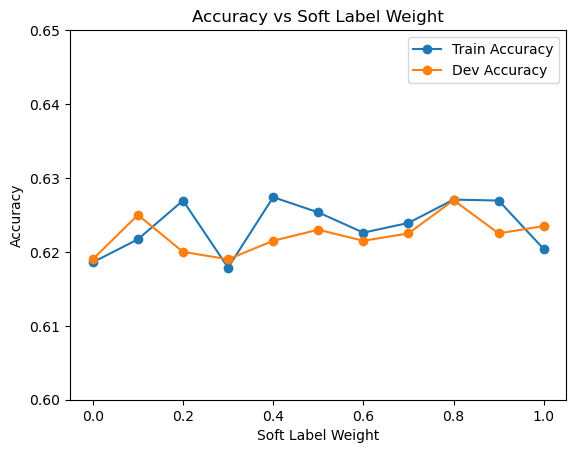

In [52]:
import matplotlib.pyplot as plt

# Your data
data = results

# Extract the necessary information
soft_label_weights = [entry['hyperparameters']['soft label weight'] for entry in data]
train_accuracies = [entry['train accuracy at best dev iter'] for entry in data]
dev_accuracies = [entry['best dev accuracy'] for entry in data]

# Plotting

plt.plot(soft_label_weights, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(soft_label_weights, dev_accuracies, marker='o', label='Dev Accuracy')

# Set the y-axis range
plt.ylim(0.6, 0.65)

plt.xlabel('Soft Label Weight')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Soft Label Weight')
plt.legend()
plt.show()

### Run the best model

In [57]:
learning_rate = 0.01
dropout_probability = 0.25
soft_label_weight = 0.8
batch_size = 1000
hidden_dim1 = 128
hidden_dim2 = 64

# Fixed parameters, model architecture
num_classes = 3
embedding_dim = 50
leaky_relu_negative_slope = 0.1

# Fixed parameters, model training
num_iterations = 10000
loss_fn = nn.CrossEntropyLoss()
check_every = 10

best_model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, 0, leaky_relu_negative_slope, dropout_probability, False, False)
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
loss_history, train_accuracy, dev_accuracy = best_model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose=True)


Iteration=0, Loss=1.0959248542785645
Iteration=10, Loss=1.0477992296218872
Iteration=20, Loss=1.0328383445739746
Iteration=30, Loss=1.0257521867752075
Iteration=40, Loss=1.005302906036377
Iteration=50, Loss=1.0012120008468628
Iteration=60, Loss=0.9961627125740051
Iteration=70, Loss=0.9779399633407593
Iteration=80, Loss=0.9838843941688538
Iteration=90, Loss=0.9838460683822632
Iteration=100, Loss=0.9989803433418274
Iteration=110, Loss=0.9955161809921265
Iteration=120, Loss=0.9812686443328857
Iteration=130, Loss=0.9635843634605408
Iteration=140, Loss=0.9664087891578674
Iteration=150, Loss=0.9661003351211548
Iteration=160, Loss=0.9593077898025513
Iteration=170, Loss=0.9712860584259033
Iteration=180, Loss=0.9717569947242737
Iteration=190, Loss=0.9860913753509521
Iteration=200, Loss=0.9817032814025879
Iteration=210, Loss=1.0061264038085938
Iteration=220, Loss=0.9782307744026184
Iteration=230, Loss=0.9613000154495239
Iteration=240, Loss=0.9687857031822205
Iteration=250, Loss=0.960879921913147

Iteration=2090, Loss=0.9611610770225525
Iteration=2100, Loss=0.9555106163024902
Iteration=2110, Loss=0.9742133617401123
Iteration=2120, Loss=0.9442141652107239
Iteration=2130, Loss=0.9572709202766418
Iteration=2140, Loss=0.9433547854423523
Iteration=2150, Loss=0.9402509927749634
Iteration=2160, Loss=0.948486328125
Iteration=2170, Loss=0.9433640241622925
Iteration=2180, Loss=0.9653905034065247
Iteration=2190, Loss=0.9505018591880798
Iteration=2200, Loss=0.9491292238235474
Iteration=2210, Loss=0.9553259015083313
Iteration=2220, Loss=0.9428950548171997
Iteration=2230, Loss=0.9769880771636963
Iteration=2240, Loss=0.9422096014022827
Iteration=2250, Loss=0.9419606924057007
Iteration=2260, Loss=0.9611989855766296
Iteration=2270, Loss=0.9545393586158752
Iteration=2280, Loss=0.941720187664032
Iteration=2290, Loss=0.9613977074623108
Iteration=2300, Loss=0.9411066174507141
Iteration=2310, Loss=0.9604606628417969
Iteration=2320, Loss=0.958000123500824
Iteration=2330, Loss=0.9299813508987427
Iterat

Iteration=4150, Loss=0.9281035661697388
Iteration=4160, Loss=0.9331568479537964
Iteration=4170, Loss=0.9086167216300964
Iteration=4180, Loss=0.927671492099762
Iteration=4190, Loss=0.9057058095932007
Iteration=4200, Loss=0.9150662422180176
Iteration=4210, Loss=0.9163451790809631
Iteration=4220, Loss=0.9179790019989014
Iteration=4230, Loss=0.9186672568321228
Iteration=4240, Loss=0.9078176021575928
Iteration=4250, Loss=0.9378233551979065
Iteration=4260, Loss=0.9198360443115234
Iteration=4270, Loss=0.9091097712516785
Iteration=4280, Loss=0.9252204298973083
Iteration=4290, Loss=0.916934609413147
Iteration=4300, Loss=0.9273425340652466
Iteration=4310, Loss=0.9128394722938538
Iteration=4320, Loss=0.9097222089767456
Iteration=4330, Loss=0.9274541735649109
Iteration=4340, Loss=0.9066203236579895
Iteration=4350, Loss=0.9160443544387817
Iteration=4360, Loss=0.9239962100982666
Iteration=4370, Loss=0.9065301418304443
Iteration=4380, Loss=0.9241147041320801
Iteration=4390, Loss=0.923827052116394
Ite

Iteration=6210, Loss=0.9188258647918701
Iteration=6220, Loss=0.9201184511184692
Iteration=6230, Loss=0.9158250689506531
Iteration=6240, Loss=0.9060255289077759
Iteration=6250, Loss=0.9222550392150879
Iteration=6260, Loss=0.9221047759056091
Iteration=6270, Loss=0.9109188318252563
Iteration=6280, Loss=0.915240466594696
Iteration=6290, Loss=0.9156370759010315
Iteration=6300, Loss=0.9012485146522522
Iteration=6310, Loss=0.9052140116691589
Iteration=6320, Loss=0.9182788729667664
Iteration=6330, Loss=0.9130785465240479
Iteration=6340, Loss=0.9267116785049438
Iteration=6350, Loss=0.9107481241226196
Iteration=6360, Loss=0.9184488654136658
Iteration=6370, Loss=0.9132473468780518
Iteration=6380, Loss=0.9197090864181519
Iteration=6390, Loss=0.927671492099762
Iteration=6400, Loss=0.9067857265472412
Iteration=6410, Loss=0.9133834838867188
Iteration=6420, Loss=0.9133964776992798
Iteration=6430, Loss=0.912344217300415
Iteration=6440, Loss=0.9242773056030273
Iteration=6450, Loss=0.9117549061775208
Ite

Iteration=8270, Loss=0.9100489020347595
Iteration=8280, Loss=0.9139161109924316
Iteration=8290, Loss=0.9263388514518738
Iteration=8300, Loss=0.910101592540741
Iteration=8310, Loss=0.9222068786621094
Iteration=8320, Loss=0.9024880528450012
Iteration=8330, Loss=0.9115491509437561
Iteration=8340, Loss=0.926374077796936
Iteration=8350, Loss=0.9065876007080078
Iteration=8360, Loss=0.9181941747665405
Iteration=8370, Loss=0.9188646078109741
Iteration=8380, Loss=0.9262548089027405
Iteration=8390, Loss=0.9286625981330872
Iteration=8400, Loss=0.9340265989303589
Iteration=8410, Loss=0.9143909215927124
Iteration=8420, Loss=0.9114135503768921
Iteration=8430, Loss=0.916234016418457
Iteration=8440, Loss=0.9067190885543823
Iteration=8450, Loss=0.9180394411087036
Iteration=8460, Loss=0.922411322593689
Iteration=8470, Loss=0.9125728011131287
Iteration=8480, Loss=0.9164543151855469
Iteration=8490, Loss=0.8990302085876465
Iteration=8500, Loss=0.9141735434532166
Iteration=8510, Loss=0.9206587076187134
Iter

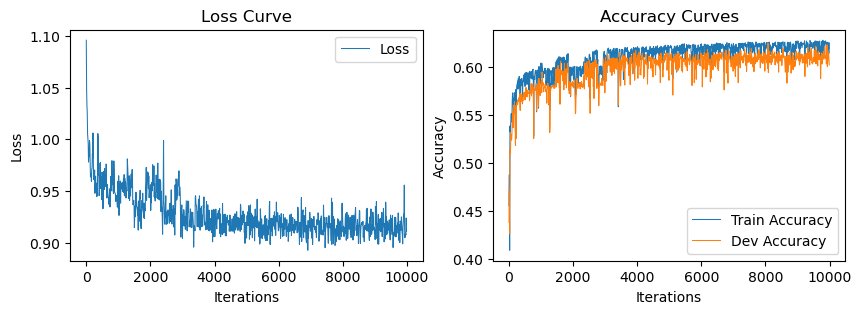

In [67]:
import matplotlib.pyplot as plt

iterations = [i * 10 for i in range(len(loss_history))] # iterations data...

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot loss history on the first subplot
ax1.plot(iterations, loss_history, label='Loss', lw=0.75)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()

# Plot accuracies on the second subplot
ax2.plot(iterations, train_accuracy, label='Train Accuracy', lw=0.75)
ax2.plot(iterations, dev_accuracy, label='Dev Accuracy', lw=0.75)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()

# Show the plots
plt.show()


In [68]:
learning_rate = 0.01
dropout_probability = 0.25
soft_label_weight = 0
batch_size = 1000
hidden_dim1 = 128
hidden_dim2 = 64

# Fixed parameters, model architecture
num_classes = 3
embedding_dim = 50
leaky_relu_negative_slope = 0.1

# Fixed parameters, model training
num_iterations = 10000
loss_fn = nn.CrossEntropyLoss()
check_every = 10

baseline_DAN = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, 0, leaky_relu_negative_slope, dropout_probability, False, False)
optimizer = torch.optim.Adam(baseline_DAN.parameters(), lr=learning_rate)
loss_history, train_accuracy, dev_accuracy = baseline_DAN.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose=True)


Iteration=0, Loss=1.0885285139083862
Iteration=10, Loss=1.027242660522461
Iteration=20, Loss=1.041053295135498
Iteration=30, Loss=1.0247058868408203
Iteration=40, Loss=1.0094683170318604
Iteration=50, Loss=1.0047203302383423
Iteration=60, Loss=0.9902735948562622
Iteration=70, Loss=1.0101381540298462
Iteration=80, Loss=0.9894310235977173
Iteration=90, Loss=0.987460196018219
Iteration=100, Loss=0.9784482717514038
Iteration=110, Loss=0.9840025901794434
Iteration=120, Loss=0.9655537009239197
Iteration=130, Loss=1.0646716356277466
Iteration=140, Loss=0.9824836254119873
Iteration=150, Loss=0.9642987847328186
Iteration=160, Loss=0.9603123664855957
Iteration=170, Loss=0.9811249375343323
Iteration=180, Loss=0.9696670770645142
Iteration=190, Loss=0.9585295915603638
Iteration=200, Loss=1.0047962665557861
Iteration=210, Loss=0.9633969664573669
Iteration=220, Loss=0.9684723615646362
Iteration=230, Loss=0.9644110798835754
Iteration=240, Loss=0.9576123952865601
Iteration=250, Loss=0.947786271572113
I

Iteration=2090, Loss=0.9618185758590698
Iteration=2100, Loss=0.9550561904907227
Iteration=2110, Loss=0.9406064748764038
Iteration=2120, Loss=0.9381712079048157
Iteration=2130, Loss=0.9363371729850769
Iteration=2140, Loss=0.9519748091697693
Iteration=2150, Loss=0.9238938093185425
Iteration=2160, Loss=0.933324933052063
Iteration=2170, Loss=0.921482264995575
Iteration=2180, Loss=0.9389544725418091
Iteration=2190, Loss=0.93348628282547
Iteration=2200, Loss=0.9643319249153137
Iteration=2210, Loss=0.9399455785751343
Iteration=2220, Loss=0.9379822611808777
Iteration=2230, Loss=0.9408054947853088
Iteration=2240, Loss=0.9310736060142517
Iteration=2250, Loss=0.9545102715492249
Iteration=2260, Loss=0.9018595814704895
Iteration=2270, Loss=0.9287023544311523
Iteration=2280, Loss=0.9277300834655762
Iteration=2290, Loss=0.9303678274154663
Iteration=2300, Loss=0.9271658658981323
Iteration=2310, Loss=0.9444338083267212
Iteration=2320, Loss=0.9330013394355774
Iteration=2330, Loss=0.9149361848831177
Iter

Iteration=4150, Loss=0.9318855404853821
Iteration=4160, Loss=0.9241802096366882
Iteration=4170, Loss=0.9069603085517883
Iteration=4180, Loss=0.9310295581817627
Iteration=4190, Loss=0.9221225380897522
Iteration=4200, Loss=0.9146918058395386
Iteration=4210, Loss=0.906134843826294
Iteration=4220, Loss=0.9279516339302063
Iteration=4230, Loss=0.9181097745895386
Iteration=4240, Loss=0.8909484148025513
Iteration=4250, Loss=0.9169103503227234
Iteration=4260, Loss=0.8976951837539673
Iteration=4270, Loss=0.9297513365745544
Iteration=4280, Loss=0.9030617475509644
Iteration=4290, Loss=0.9120279550552368
Iteration=4300, Loss=0.9117124080657959
Iteration=4310, Loss=0.9369221329689026
Iteration=4320, Loss=0.9147611856460571
Iteration=4330, Loss=0.9112275838851929
Iteration=4340, Loss=0.9281116127967834
Iteration=4350, Loss=0.9263076782226562
Iteration=4360, Loss=0.9048717617988586
Iteration=4370, Loss=0.92313152551651
Iteration=4380, Loss=0.9113330245018005
Iteration=4390, Loss=0.920246422290802
Iter

Iteration=6210, Loss=0.9156532883644104
Iteration=6220, Loss=0.913910448551178
Iteration=6230, Loss=0.9199516177177429
Iteration=6240, Loss=0.9246274828910828
Iteration=6250, Loss=0.9278907179832458
Iteration=6260, Loss=0.906621515750885
Iteration=6270, Loss=0.8954688310623169
Iteration=6280, Loss=0.9097052216529846
Iteration=6290, Loss=0.9047282338142395
Iteration=6300, Loss=0.9204365611076355
Iteration=6310, Loss=0.9131746292114258
Iteration=6320, Loss=0.9276635646820068
Iteration=6330, Loss=0.9092298746109009
Iteration=6340, Loss=0.9166369438171387
Iteration=6350, Loss=0.9094070792198181
Iteration=6360, Loss=0.9043735861778259
Iteration=6370, Loss=0.9278938174247742
Iteration=6380, Loss=0.9091252088546753
Iteration=6390, Loss=0.901544451713562
Iteration=6400, Loss=0.9021129608154297
Iteration=6410, Loss=0.9241980910301208
Iteration=6420, Loss=0.9109318256378174
Iteration=6430, Loss=0.9086185693740845
Iteration=6440, Loss=0.9104467034339905
Iteration=6450, Loss=0.9264398813247681
Ite

Iteration=8270, Loss=0.9193779826164246
Iteration=8280, Loss=0.8974387645721436
Iteration=8290, Loss=0.931049108505249
Iteration=8300, Loss=0.9147986173629761
Iteration=8310, Loss=0.9016770720481873
Iteration=8320, Loss=0.9324605464935303
Iteration=8330, Loss=0.9262558817863464
Iteration=8340, Loss=0.907590389251709
Iteration=8350, Loss=0.9092491865158081
Iteration=8360, Loss=0.9088373780250549
Iteration=8370, Loss=0.9015715718269348
Iteration=8380, Loss=0.9123635292053223
Iteration=8390, Loss=0.9544125199317932
Iteration=8400, Loss=0.9306545853614807
Iteration=8410, Loss=0.9151895642280579
Iteration=8420, Loss=0.9161475896835327
Iteration=8430, Loss=0.9023685455322266
Iteration=8440, Loss=0.9001863598823547
Iteration=8450, Loss=0.9149475693702698
Iteration=8460, Loss=0.9098836779594421
Iteration=8470, Loss=0.9196987748146057
Iteration=8480, Loss=0.9066348671913147
Iteration=8490, Loss=0.9217165112495422
Iteration=8500, Loss=0.9137462973594666
Iteration=8510, Loss=0.905043363571167
Ite

In [96]:
print("best dev acc for baseline DAN", dev_accuracy[np.argmax(dev_accuracy)])
print("best train acc for baseline DAN", train_accuracy[np.argmax(dev_accuracy)])

best dev acc for baseline DAN 0.619
best train acc for baseline DAN 0.624224487558917


# Test Set

In [82]:
test

,text,label,sentiment,Y_hard
0,@user @user what do these '1/2 naked pics' hav...,1,neutral,"[0.0, 1.0, 0.0]"
1,OH: “I had a blue penis while I was this” [pla...,1,neutral,"[0.0, 1.0, 0.0]"
2,"@user @user That's coming, but I think the vic...",1,neutral,"[0.0, 1.0, 0.0]"
3,I think I may be finally in with the in crowd ...,2,positive,"[0.0, 0.0, 1.0]"
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0,negative,"[1.0, 0.0, 0.0]"
...,...,...,...,...
12279,Sentinel Editorial: FBI’s Comey ‘had no one of...,1,neutral,"[0.0, 1.0, 0.0]"
12280,perfect pussy clips #vanessa hudgens zac efron...,1,neutral,"[0.0, 1.0, 0.0]"
12281,#latestnews 4 #newmexico #politics + #nativeam...,1,neutral,"[0.0, 1.0, 0.0]"
12282,Trying to have a conversation with my dad abou...,0,negative,"[1.0, 0.0, 0.0]"


In [108]:
Y_test = test['label']

In [109]:
Y_pred_test = best_model.predict(Xmat_test)
print("best student model test acc", best_model.accuracy(Y_pred_test, Y_test))

best student model test acc 0.6291924454575057


In [110]:
Y_pred_test_baseline_DAN = baseline_DAN.predict(Xmat_test)
print("baseline DAN model test acc", baseline_DAN.accuracy(Y_pred_test_baseline_DAN, Y_test))

baseline DAN model test acc 0.6020026050146532


### Results - Test Accuracy

```
best student model test acc 0.6291924454575057
baseline DAN model test acc 0.6020026050146532
Baseline Embedding test accuracy: 0.6101432758059264
Baseline BOW Test accuracy: 0.5902800390752198

dev acc for baseline DAN 0.619
Baseline BOW dev accuracy: 0.6775
Baseline Embedding dev accuracy: 0.612
best student model dev acc 62.7%

train acc for baseline DAN 0.624224487558917
Baseline Embedding train accuracy: 0.6146443056012276
Baseline BOW train accuracy: Train accuracy: 0.9095472980379261
best student model train acc 62.6%
```

In [113]:
total_baseline_DAN = [0, 0, 0]
wrong_baseline_DAN = [0, 0, 0]
for y, y_pred in zip(Y_test, Y_pred_test_baseline_DAN):
    total_baseline_DAN[y] += 1
    if y != y_pred:
        # if the prediction is wrong
        wrong_baseline_DAN[y] += 1

percent_error_baseline_DAN = []

for i in range(len(total_baseline_DAN)):
    percent_error_baseline_DAN.append(wrong_baseline_DAN[i]/total_baseline_DAN[i])

In [114]:
percent_error_baseline_DAN

[0.6754783484390735, 0.12329459322890349, 0.6206315789473684]

# Plot the evaluation bars

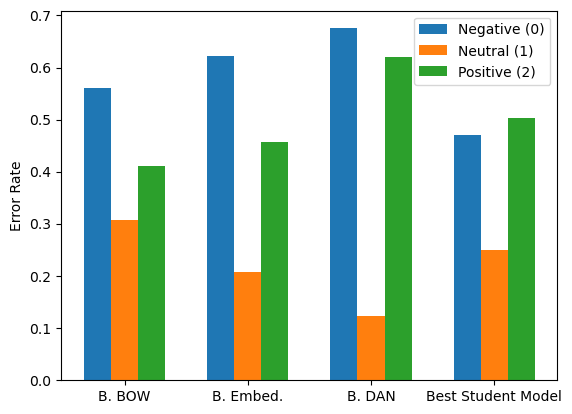

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['B. BOW', 'B. Embed.', 'B. DAN', 'Best Student Model']
label_0 = [0.5599194360523666, 0.6226082578046325, 0.6754783484390735, 0.47129909365558914]
label_1 = [0.3084049183089102, 0.20683847060805122, 0.12329459322890349, 0.25080006737409466]
label_2 = [0.41178947368421054, 0.45810526315789474, 0.6206315789473684, 0.5027368421052631]

# Number of models
N = len(models)

# The x locations for the models
ind = np.arange(0, 2*N, 2)  # increase spaces between groups

# The width of the bars
width = 0.44

fig = plt.figure()
ax = fig.add_subplot(111)

# Bars for label 0
rects1 = ax.bar(ind, label_0, width, color='#1f77b4')

# Bars for label 1
rects2 = ax.bar(ind+width, label_1, width, color='#ff7f0e')

# Bars for label 2
rects3 = ax.bar(ind+width*2, label_2, width, color='#2ca02c')

# Add labels, title, and axes ticks
ax.set_ylabel('Error Rate')
ax.set_xticks(ind+width)
ax.set_xticklabels(models)
ax.legend((rects1[0], rects2[0], rects3[0]), ('Negative (0)', 'Neutral (1)', 'Positive (2)'))

# Plot
plt.show()
